<a href="https://colab.research.google.com/github/Laimo64/SAM-Liver/blob/main/SAMed_Liver_Contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#SAMed
!pip install -q gdown==4.6.0 einops==0.6.1 icecream==2.1.3 MedPy==0.4.0 monai==1.1.0 opencv_python==4.5.4.58 SimpleITK==2.2.1 tensorboardX==2.6 ml-collections==0.1.1 onnx==1.13.1 onnxruntime==1.14.1 tensorboardX torchmetrics
# prepare codes
import os
CODE_DIR = 'samed_codes'
os.makedirs(f'./{CODE_DIR}')
!git clone https://github.com/hitachinsk/SAMed.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

# from google.colab import drive
# drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Reason for being yanked: deprecated, use  4.5.4.60
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.0 MB/s eta 0:00:

In [2]:

# this is the small dataset based on L3D_Dataset, change to L3D_Dataset when the code is ready
# !gdown --fuzzy https://drive.google.com/file/d/18KVLU4y0BPoRqtHnhsE3KbTQb2BEUXTz/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/1JyTYDCkv3RGUnkE--l-Kf9v5PLOCI3k1/view?usp=drive_link  #L3D_dataset
!ls

Downloading...
From: https://drive.google.com/uc?id=1JyTYDCkv3RGUnkE--l-Kf9v5PLOCI3k1
To: /content/samed_codes/L3D_Dataset.zip
100% 3.64G/3.64G [01:04<00:00, 56.1MB/s]
datasets	 preprocess				 sam_lora_image_encoder.py  train.py
L3D_Dataset.zip  README.md				 segment_anything	    utils.py
LICENSE		 requirements.txt			 subsample_datasets.py
lists		 SAMed_h				 test.py
materials	 sam_lora_image_encoder_mask_decoder.py  trainer.py


In [3]:
!gdown 1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr
!gdown 1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg

Downloading...
From: https://drive.google.com/uc?id=1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr
To: /content/samed_codes/epoch_159.pth
100% 19.7M/19.7M [00:00<00:00, 64.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg
To: /content/samed_codes/sam_vit_b_01ec64.pth
100% 375M/375M [00:11<00:00, 33.0MB/s]


In [4]:
# !unzip -q test_dataset.zip
!unzip -q L3D_Dataset.zip

In [5]:
!pwd

/content/samed_codes


In [6]:
%cd /content/samed_codes
import os
import cv2
import json
import random
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as iio
from torchvision.transforms import InterpolationMode
from scipy import ndimage
from scipy.ndimage import zoom
from glob import glob
from einops import repeat

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def random_rot_flip(image, label):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label

def random_rotate(image, label):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label

class SegmentationDataset(Dataset):
    def __init__(self, root='/content/samed_codes/test_dataset/Train', low_res=None, transform_img=None, transform_mask=None, istrain=False):
        self.img_path_all = glob(root + '/images/*.jpg')  # Update the path and pattern
        self.mask_path_all = glob(root + '/masks_gt/*.png')  # Update the path and pattern
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.istrain = istrain
        self.low_res = low_res

        self.brightness = 0.1
        self.contrast = 0.1
        self.saturation = 0.1
        self.hue = 0.1
        self.color_aug = transforms.ColorJitter(self.brightness, self.contrast, self.saturation, self.hue)

    def __len__(self):
        return len(self.img_path_all)

    def __getitem__(self, idx):
        img_path = self.img_path_all[idx]
        mask_path = self.mask_path_all[idx]
        # print(f"Found {len(self.img_path_all)} images and {len(self.mask_path_all)} masks")

        # Open image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L') #29(3), 76(1), 150 (2)
        mask = np.array(mask)
        # class mapping
        mask[mask==0] = 0   #background
        mask[mask==76] = 1  #red
        mask[mask==150] = 2 #green
        mask[mask==29] = 3 #blue
        mask = Image.fromarray(mask)
        # Apply transformations if provided
        if self.istrain:
            hflip = random.random() < 0.5
            flip_container = random.choice([Image.FLIP_LEFT_RIGHT, Image.FLIP_TOP_BOTTOM])
            if hflip:
                image = self.color_aug(image)
                image = image.transpose(flip_container)
                mask = mask.transpose(flip_container)
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)  # Convert first channel of mask to Image format
        # image = transforms.ToTensor()(image)  # **Converting image to tensor**
        mask = torch.from_numpy(np.array(mask)).long()
        sample = {'image': image, 'mask': mask}

        if self.low_res:
            low_res_label = zoom(mask, (self.low_res/mask.shape[0], self.low_res/mask.shape[1]), order=0)
            sample = {'image': image, 'mask': mask, 'low_res_label': low_res_label}

        return sample

transform_img = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

transform_mask = transforms.Compose([
    transforms.Resize((512, 512), interpolation=InterpolationMode.NEAREST),
    # transforms.ToTensor(),
    ])
ds = SegmentationDataset(transform_img=transform_img, transform_mask=transform_mask, istrain=True)
for sample in ds:
    print(np.unique(sample['mask']))  # Check unique values in the mask (class IDs)
    plt.subplot(121); plt.imshow(sample['image'].permute(1, 2, 0))  # Rearrange image channels for display
    plt.subplot(122); plt.imshow(sample['mask'])  # Display the mask
    break



/content


LoRA

In [13]:
%cd /content/samed_codes
from segment_anything import build_sam, SamPredictor
from segment_anything import sam_model_registry

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.parameter import Parameter
from segment_anything.modeling import Sam
from safetensors import safe_open
from safetensors.torch import save_file

from icecream import ic

class _LoRA_qkv_v0_v2(nn.Module):

    def __init__(
            self,
            qkv: nn.Module,
            linear_a_q: nn.Module,
            linear_b_q: nn.Module,
            linear_a_v: nn.Module,
            linear_b_v: nn.Module,
            conv_se_q: nn.Module,
            conv_se_v: nn.Module,
    ):
        super().__init__()
        self.qkv = qkv
        self.linear_a_q = linear_a_q
        self.linear_b_q = linear_b_q
        self.linear_a_v = linear_a_v
        self.linear_b_v = linear_b_v
        self.conv_se_q = conv_se_q
        self.conv_se_v = conv_se_v

        self.dim = qkv.in_features
        self.w_identity = torch.eye(qkv.in_features)

    def forward(self, x):
        qkv = self.qkv(x)
        a_q_out = self.linear_a_q(x)
        a_v_out = self.linear_a_v(x)
        a_q_out_temp = self.conv_se_q(a_q_out.permute(0,3,1,2)).permute(0,2,3,1)
        a_v_out_temp = self.conv_se_v(a_v_out.permute(0,3,1,2)).permute(0,2,3,1)

        new_q = self.linear_b_q(torch.mul(a_q_out, torch.sigmoid(a_q_out_temp)))#SE = Squeeze and Excitation
        new_v = self.linear_b_v(torch.mul(a_v_out, torch.sigmoid(a_v_out_temp)))

        qkv[:, :, :, : self.dim] += new_q
        qkv[:, :, :, -self.dim:] += new_v
        return qkv

class LoRA_Sam_v0_v2(nn.Module):

    def __init__(self, sam_model: Sam, r: int, lora_layer=None):
        super(LoRA_Sam_v0_v2, self).__init__()

        assert r > 0
        if lora_layer:
            self.lora_layer = lora_layer
        else:
            self.lora_layer = list(
                range(len(sam_model.image_encoder.blocks)))  # Only apply lora to the image encoder by default
        # create for storage, then we can init them or load weights
        self.w_As = []  # These are linear layers
        self.w_Bs = []

        # lets freeze first
        for param in sam_model.image_encoder.parameters():
            param.requires_grad = False

        # Here, we do the surgery
        for t_layer_i, blk in enumerate(sam_model.image_encoder.blocks):
            # If we only want few lora layer instead of all
            if t_layer_i not in self.lora_layer:
                continue
            w_qkv_linear = blk.attn.qkv
            self.dim = w_qkv_linear.in_features
            w_a_linear_q = nn.Linear(self.dim, r, bias=False)
            w_b_linear_q = nn.Linear(r, self.dim, bias=False)
            w_a_linear_v = nn.Linear(self.dim, r, bias=False)
            w_b_linear_v = nn.Linear(r, self.dim, bias=False)

            conv_se_q = nn.Conv2d(r, r, kernel_size=1,
                                    stride=1, padding=0, bias=False)
            conv_se_v = nn.Conv2d(r, r, kernel_size=1,
                                    stride=1, padding=0, bias=False)
            self.w_As.append(w_a_linear_q)
            self.w_Bs.append(w_b_linear_q)
            self.w_As.append(w_a_linear_v)
            self.w_Bs.append(w_b_linear_v)
            self.w_As.append(conv_se_q)
            self.w_As.append(conv_se_v)
            blk.attn.qkv = _LoRA_qkv_v0_v2(
                w_qkv_linear,
                w_a_linear_q,
                w_b_linear_q,
                w_a_linear_v,
                w_b_linear_v,
                conv_se_q,
                conv_se_v,
            )
        self.reset_parameters()
        self.sam = sam_model

    def save_lora_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.

        save both lora and fc parameters.
        """

        assert filename.endswith(".pt") or filename.endswith('.pth')

        num_layer = len(self.w_As)  # actually, it is half
        a_tensors = {f"w_a_{i:03d}": self.w_As[i].weight for i in range(num_layer)}
        num_layer = len(self.w_Bs)  # actually, it is half
        b_tensors = {f"w_b_{i:03d}": self.w_Bs[i].weight for i in range(num_layer)}
        prompt_encoder_tensors = {}
        mask_decoder_tensors = {}

        # save prompt encoder, only `state_dict`, the `named_parameter` is not permitted
        if isinstance(self.sam, torch.nn.DataParallel) or isinstance(self.sam, torch.nn.parallel.DistributedDataParallel):
            state_dict = self.sam.module.state_dict()
        else:
            state_dict = self.sam.state_dict()
        for key, value in state_dict.items():
            if 'prompt_encoder' in key:
                prompt_encoder_tensors[key] = value
            if 'mask_decoder' in key:
                mask_decoder_tensors[key] = value

        merged_dict = {**a_tensors, **b_tensors, **prompt_encoder_tensors, **mask_decoder_tensors}
        torch.save(merged_dict, filename)

    def load_lora_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.\

        load both lora and fc parameters.
        """

        assert filename.endswith(".pt") or filename.endswith('.pth')

        state_dict = torch.load(filename)

        for i, w_A_linear in enumerate(self.w_As):
            saved_key = f"w_a_{i:03d}"
            # print('mobarak:', saved_key)
            saved_tensor = state_dict[saved_key]
            w_A_linear.weight = Parameter(saved_tensor)

        for i, w_B_linear in enumerate(self.w_Bs):
            saved_key = f"w_b_{i:03d}"
            saved_tensor = state_dict[saved_key]
            w_B_linear.weight = Parameter(saved_tensor)

        sam_dict = self.sam.state_dict()
        sam_keys = sam_dict.keys()

        # load prompt encoder
        prompt_encoder_keys = [k for k in sam_keys if 'prompt_encoder' in k]
        prompt_encoder_values = [state_dict[k] for k in prompt_encoder_keys]
        prompt_encoder_new_state_dict = {k: v for k, v in zip(prompt_encoder_keys, prompt_encoder_values)}
        sam_dict.update(prompt_encoder_new_state_dict)

        # load mask decoder
        mask_decoder_keys = [k for k in sam_keys if 'mask_decoder' in k]
        mask_decoder_values = [state_dict[k] for k in mask_decoder_keys]
        mask_decoder_new_state_dict = {k: v for k, v in zip(mask_decoder_keys, mask_decoder_values)}
        sam_dict.update(mask_decoder_new_state_dict)
        self.sam.load_state_dict(sam_dict)

    def reset_parameters(self) -> None:
        for w_A in self.w_As:
            nn.init.kaiming_uniform_(w_A.weight, a=math.sqrt(5))
        for w_B in self.w_Bs:
            nn.init.zeros_(w_B.weight)

    def forward(self, batched_input, multimask_output, image_size):
        return self.sam(batched_input, multimask_output, image_size)

/content


Visualize & Save Check point

In [21]:
def plot_inference(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()  # Disable dropout and batch normalization
    num_samples_to_plot = 5  # Number of images to visualize

    fig, axs = plt.subplots(num_samples_to_plot, 3, figsize=(12, num_samples_to_plot * 4),
                            subplot_kw=dict(xticks=[], yticks=[]))
    fig.suptitle("Input Image | Predicted Mask | Ground Truth", fontsize=16)

    num_classes = args.num_classes + 1  # Include extra class

    with torch.no_grad():  # Disable gradient calculation
        for i_batch, sampled_batch in enumerate(testloader):
            # Break early if we have plotted enough samples
            if i_batch >= num_samples_to_plot:
                break

            try:
                image_batch, label_batch, low_res_label_batch = (
                    sampled_batch['image'],
                    sampled_batch['mask'],
                    sampled_batch['low_res_label']
                )
                image_batch = image_batch.to(device, dtype=torch.float32)
                label_batch = label_batch.to(device, dtype=torch.long)
            except Exception as e:
                print(f"Error loading data for batch {i_batch + 1}: {e}")
                continue  # Skip this batch

            outputs = model(image_batch, multimask_output, args.img_size)
            logits = outputs['masks']
            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)

            # Convert to NumPy arrays for visualization
            input_image = image_batch[0].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
            pred_mask = pred_seg[0].cpu().numpy()  # Predicted segmentation
            true_mask = label_batch[0].cpu().numpy()  # Ground truth

            # Normalize image if needed
            input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())

            # Plot the images
            axs[i_batch, 0].imshow(input_image)
            axs[i_batch, 0].set_title("Input Image")

            axs[i_batch, 1].imshow(pred_mask, cmap="jet", interpolation="none")
            axs[i_batch, 1].set_title("Predicted Mask")

            axs[i_batch, 2].imshow(true_mask, cmap="jet", interpolation="none")
            axs[i_batch, 2].set_title("Ground Truth Mask")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()


def save_checkpoint(net, optimizer, epoch, best_loss, best_epoch, epoch_since_improvement, best_result, checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'best_loss': best_loss,
        'best_epoch': best_epoch,
        'epoch_since_improvement': epoch_since_improvement,  # 儲存 epoch_since_improvement
        'best_result': best_result,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch} with loss {best_loss} and best epoch {best_epoch}")



def load_checkpoint(model, optimizer, filename):
  if os.path.isfile(filename):
    print("=> loading checkpoint '{}'".format(filename))
    checkpoint = torch.load(filename, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    start_epoch = checkpoint.get('epoch', 0) + 1
    best_loss = checkpoint.get('best_loss', np.inf)
    best_epoch = checkpoint.get('best_epoch', 0)
    epoch_since_improvement = checkpoint.get('epoch_since_improvement', 0)
    best_result = checkpoint.get('best_result', None)

    print("=> loaded checkpoint '{}' (epoch {})".format(filename, checkpoint.get('epoch', 'N/A')))  # load epoch

    return start_epoch, best_loss, best_epoch, epoch_since_improvement, best_result
    # return start_epoch, best_loss, best_epoch, best_result
  else:
    print("=> no checkpoint found at '{}'".format(filename))
    return 1, [0, 0], 0, 0, None

SAM Training

/content
Training on: cuda train sample size: 921 test sample size: 109 batch: 6
=> no checkpoint found at 'checkpoint.pth'
No checkpoint loaded; starting training from scratch.
Checkpoint saved at epoch 0 with loss inf and best epoch 0
--- Epoch 0/30: Training loss = 0.6136, Testing: [loss = 0.6029, dice = 0.3165], Best loss = 0.6029, Best epoch = 0, lr = 0.003080
Checkpoint saved at epoch 1 with loss 0.6028630545264796 and best epoch 0
--- Epoch 1/30: Training loss = 0.5984, Testing: [loss = 0.6020, dice = 0.3389], Best loss = 0.6020, Best epoch = 1, lr = 0.004991
Checkpoint saved at epoch 2 with loss 0.6019693518939772 and best epoch 1
--- Epoch 2/30: Training loss = 0.5924, Testing: [loss = 0.5939, dice = 0.3374], Best loss = 0.5939, Best epoch = 2, lr = 0.004968
Checkpoint saved at epoch 3 with loss 0.5938589290568703 and best epoch 2
--- Epoch 3/30: Training loss = 0.5911, Testing: [loss = 0.5858, dice = 0.3365], Best loss = 0.5858, Best epoch = 3, lr = 0.004945
Checkpoint saved 

<ipython-input-13-84fc6d378b6b>:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename)


Class Wise Dice: {'dice_cls:1': 0, 'dice_cls:2': 0, 'dice_cls:3': 0}
Overall Dice: 0.0


AttributeError: 'NoneType' object has no attribute 'num_classes'

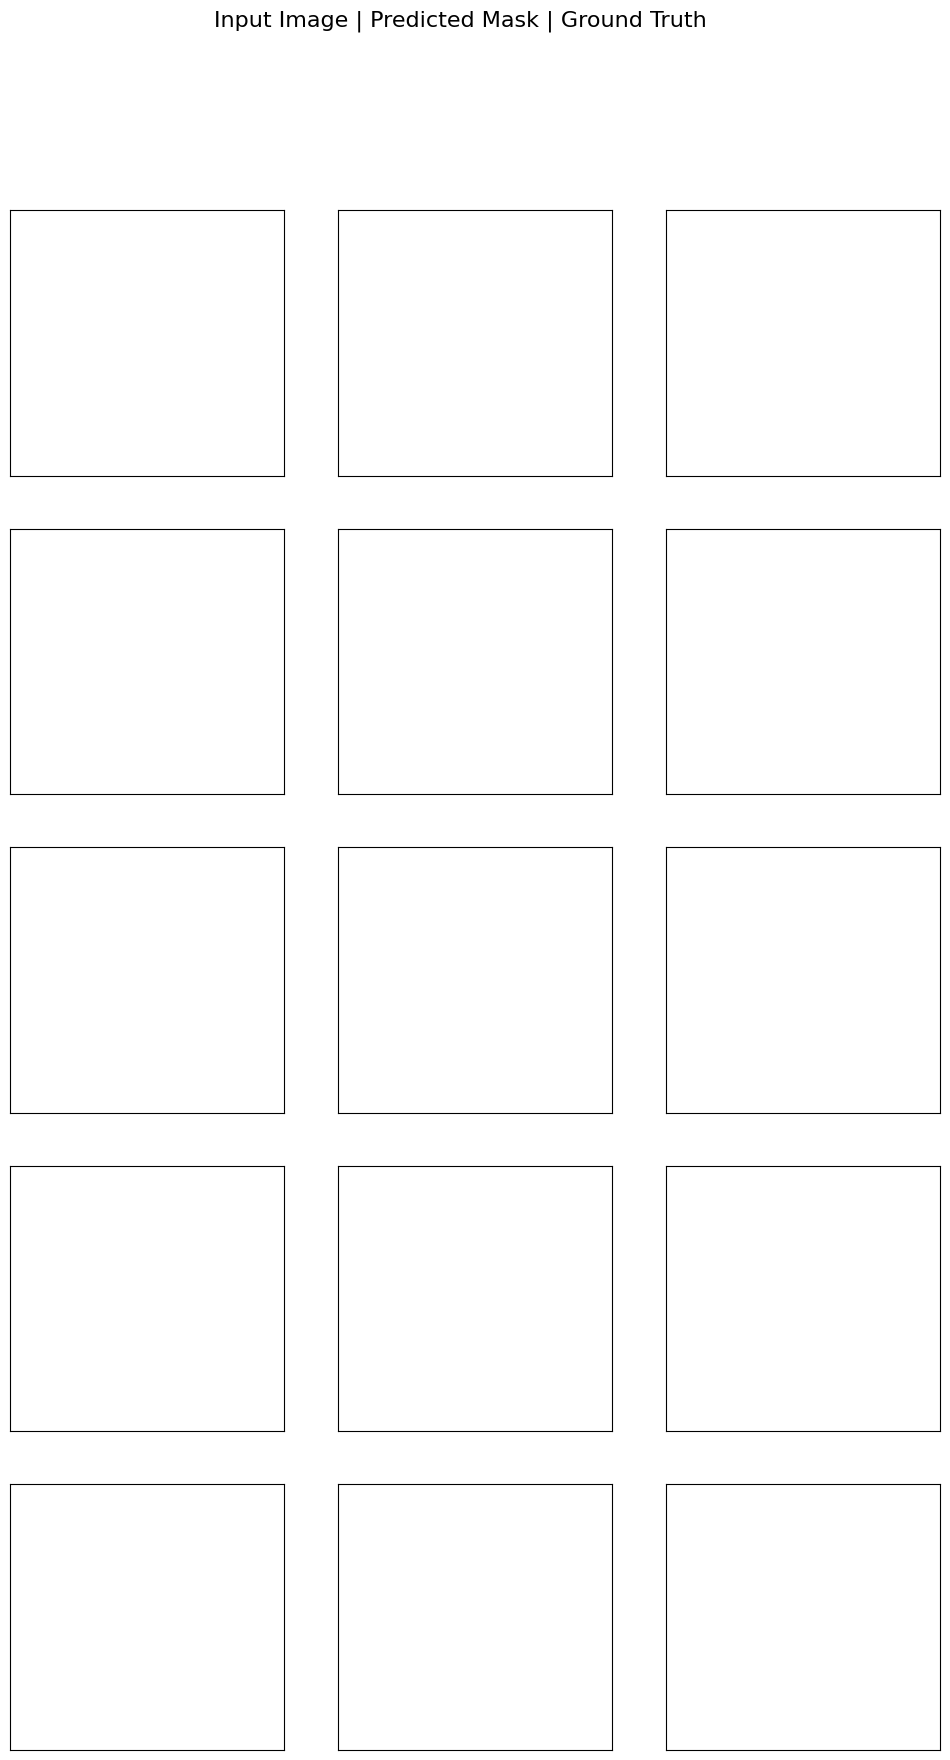

In [22]:
%cd /content/samed_codes
import os
import cv2

import sys
from tqdm import tqdm
import logging
import numpy as np
import argparse
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from importlib import import_module
from segment_anything import sam_model_registry
from datasets.dataset_synapse import Synapse_dataset
from icecream import ic
from medpy import metric
from scipy.ndimage import zoom
import torch.nn as nn
import SimpleITK as sitk
import torch.nn.functional as F
import imageio
from einops import repeat

from torch.nn.modules.loss import CrossEntropyLoss
from utils import DiceLoss
import torch.optim as optim
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

def adjust_learning_rate(optimizer, iter_num, args):
    if args.warmup and iter_num < args.warmup_period:
        lr_ = args.base_lr * ((iter_num + 1) / args.warmup_period)
    else:
        if args.warmup:
            shift_iter = iter_num - args.warmup_period
            assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
        else:
            shift_iter = iter_num
        lr_ = args.base_lr * (1.0 - shift_iter / args.max_iterations) ** 0.9
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_
    return lr_

def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]
        false_positives = confusion_matrix[:, index].sum() - true_positives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        denom = 2 * true_positives + false_positives + false_negatives
        if denom == 0:
            dice = 0
        else:
            dice = 2 * float(true_positives) / denom
        dices.append(dice)
    return dices

def inference_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    # fig, axs = plt.subplots(len(testloader), 3, figsize=(1*3, len(testloader)*1), subplot_kw=dict(xticks=[],yticks=[]))
    loss_per_epoch, dice_per_epoch = [], []
    num_classes = args.num_classes + 1
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    class_wise_dice = []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['mask'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            outputs = model(image_batch, multimask_output, args.img_size)
            logits = outputs['masks']
            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)
            confusion_matrix += calculate_confusion_matrix_from_arrays(pred_seg.cpu(), label_batch.cpu(), num_classes)
            loss, loss_ce, loss_dice = calc_loss(logits, label_batch, ce_loss, dice_loss, args)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice.item())
            low_res_logits = outputs['low_res_logits']
            loss_dice = dice_loss(low_res_logits, low_res_label_batch, softmax=True)
            img_num = 0
            metric_list = []
            pred_seg, label_batch = pred_seg.cpu().detach().numpy(), label_batch.cpu().detach().numpy()

        confusion_matrix = confusion_matrix[1:, 1:]  # exclude background
        dices_per_class = {'dice_cls:{}'.format(cls + 1): dice
                    for cls, dice in enumerate(calculate_dice(confusion_matrix))}

    return np.mean(loss_per_epoch), np.mean(dice_per_epoch), dices_per_class
def seed_everything(seed=42):
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def calc_loss(output, label_batch, ce_loss, dice_loss, args):
    # print("label_batch",label_batch.shape)
    # print(output.shape)
    loss_ce = ce_loss(output, label_batch[:].long())
    loss_dice = dice_loss(output, label_batch, softmax=True)
    loss = (1 - args.dice_weight) * loss_ce + args.dice_weight * loss_dice
    return loss, loss_ce, loss_dice


def training_per_epoch(model, trainloader, optimizer, iter_num, ce_loss, dice_loss, multimask_output=True, args=None):
    model.train()
    loss_all = []

    for i_batch, sampled_batch in enumerate(trainloader):
        image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['mask'], sampled_batch['low_res_label']
        image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
        batch_dict = {'image_batch':label_batch, 'label_batch':label_batch, 'low_res_label_batch':low_res_label_batch}
        outputs = model(image_batch, multimask_output, args.img_size)
        output = outputs[args.output_key]
        loss_label_batch = batch_dict[args.batch_key]
        loss, loss_ce, loss_dice = calc_loss(output, loss_label_batch, ce_loss, dice_loss, args)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        # Update learning rate and increment iteration count
        lr_current = adjust_learning_rate(optimizer, iter_num, args)
        iter_num += 1

        loss_all.append(loss.item())


    return np.mean(loss_all), iter_num, lr_current


def test_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    loss_per_epoch, dice_per_epoch = [], []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['mask'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            batch_dict = {'image_batch':image_batch, 'label_batch':label_batch, 'low_res_label_batch':low_res_label_batch}
            outputs = model(image_batch, multimask_output, args.img_size)
            output = outputs[args.output_key]
            loss_label_batch = batch_dict[args.batch_key]
            loss, loss_ce, loss_dice = calc_loss(output, loss_label_batch, ce_loss, dice_loss, args)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice.item())
    return np.mean(loss_per_epoch), np.mean(dice_per_epoch)



def main():
    parser = argparse.ArgumentParser()
    # Add new arguments
    parser.add_argument('--batch_key', type=str, default='low_res_label_batch', help='Key for accessing label batch')
    parser.add_argument('--output_key', type=str, default='low_res_logits', help='Key for accessing model outputs')



    parser.add_argument('--dice_weight', type=float, default=0.8, help='Weight for dice loss in the loss calculation')
    parser.add_argument('--weights', type=int, nargs='+', default=None,help='List of weights for each class. Provide space-separated values.')

    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='/content/samed_codes/L3D_Dataset')
    parser.add_argument('--data_path', type=str, default='L3D_Dataset')    ##### remember to change to L3D when the code is working
    # parser.add_argument('--data_path', type=str, default='Endonasal_Slices_Voxel')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=3)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='results')
    parser.add_argument('--output_file', type=str, default='model_best.pt') ############
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int, default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=6, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    parser.add_argument('--base_lr', type=float, default=0.005, help='segmentation network learning rate')
    parser.add_argument('--batch_size', type=int, default=6, help='batch_size per gpu')
    parser.add_argument('--warmup', type=bool, default=True, help='If activated, warp up the learning from a lower lr to the base_lr')
    parser.add_argument('--warmup_period', type=int, default=250, help='Warp up iterations, only valid whrn warmup is activated')
    parser.add_argument('--AdamW', type=bool, default=True, help='If activated, use AdamW to finetune SAM model')
    parser.add_argument('--max_epochs', type=int, default=30, help='maximum epoch number to train')
    parser.add_argument('--max_iterations', type=int, default=30000, help='maximum epoch number to train')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    args.output_dir = 'results'
    args.ckpt = 'sam_vit_b_01ec64.pth'
    args.lora_ckpt = 'results/' + args.output_file
    os.makedirs(args.output_dir, exist_ok = True)

    sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                                    num_classes=args.num_classes,
                                                                    checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                                    pixel_std=[1, 1, 1])

    # pkg = import_module(args.module)
    net = LoRA_Sam_v0_v2(sam, args.rank).cuda()
    # net.load_lora_parameters(args.lora_ckpt)
    multimask_output = True if args.num_classes > 1 else False

    transform_img = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

    transform_mask = transforms.Compose([
        transforms.Resize((512, 512), interpolation=InterpolationMode.NEAREST),
        # transforms.ToTensor(),
        ])
# ds = SegmentationDataset(transform_img=transform_img, transform_mask=transform_mask, istrain=True)

    train_dataset = SegmentationDataset(root=(args.data_path+'/Train'), low_res=128, transform_img=transform_img, transform_mask=transform_mask, istrain=True)
    test_dataset = SegmentationDataset(root=(args.data_path+'/Test'), low_res=128, transform_img=transform_img, transform_mask=transform_mask)
    trainloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
    print('Training on:', device, 'train sample size:', len(train_dataset), 'test sample size:', len(test_dataset), 'batch:', args.batch_size)

    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes + 1)
    b_lr = args.base_lr / args.warmup_period
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
    iter_num = 0

    # # test if there is low_res_label
    # for i_batch, sampled_batch in enumerate(trainloader):
    #   print(f"Sampled batch keys: {sampled_batch.keys()}")  # 確認是否有 'low_res_label'



    best_epoch, best_loss = 0.0, np.inf
    ######### load checkpoint
    start_epoch, best_loss, best_epoch, epoch_since_improvement, best_result = load_checkpoint(net, optimizer, 'checkpoint.pth')
    # start_epoch, best_loss, best_epoch, best_result = load_checkpoint(net, optimizer, 'checkpoint.pth')

    if start_epoch == 1 and isinstance(best_loss, list) and best_loss == [0, 0]:
        print("No checkpoint loaded; starting training from scratch.")
        best_loss = np.inf
    else:
        print(f"Resuming training from epoch {start_epoch} with best loss {best_loss}, best epoch {best_epoch}.")
    ########

    for epoch in range(args.max_epochs):
        loss_training, iter_num, lr_current = training_per_epoch(net, trainloader, optimizer, iter_num, ce_loss, dice_loss, multimask_output=multimask_output, args=args)
        loss_testing, dice = test_per_epoch(net, testloader, ce_loss, dice_loss,multimask_output=True, args=args)

        ##### save checkpoint
        checkpoint_path = '/content/samed_codes/checkpoint.pth'
        save_checkpoint(net, optimizer, epoch, best_loss, best_epoch, epoch_since_improvement, best_result, checkpoint_path)
        # save_checkpoint(net, optimizer, epoch, best_loss, best_epoch, best_result, checkpoint_path)
        #####

        if loss_testing < best_loss:
            best_loss = loss_testing
            best_epoch = epoch
            net.save_lora_parameters(os.path.join(args.output_dir, args.output_file))

        print('--- Epoch {}/{}: Training loss = {:.4f}, Testing: [loss = {:.4f}, dice = {:.4f}], Best loss = {:.4f}, Best epoch = {}, lr = {:.6f}'.\
    format(epoch, args.max_epochs, loss_training, loss_testing, dice, best_loss, best_epoch, lr_current))

    assert args.lora_ckpt is not None
    net.load_lora_parameters(args.lora_ckpt)
    testloader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=2)
    test_loss, overall_dice, dices_per_class = inference_per_epoch(net, testloader, ce_loss, dice_loss, multimask_output=True, args=args)
    dices_per_class_list = np.array(list(dices_per_class.values()))
    print('Class Wise Dice:', dices_per_class)
    print('Overall Dice:', np.mean(dices_per_class_list))
    plot_inference(net, testloader, ce_loss, dice_loss, multimask_output=True, args=None)  # visualize

if __name__ == '__main__':
    seed_everything()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # safe checkpoint
    checkpoint_path = 'checkpoints'
    os.makedirs(checkpoint_path, exist_ok=True)
    main()